In [19]:
%%capture

! pip install transformers pytorch-lightning --quiet
! pip install matplotlib accelerate datasets
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [27]:
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
import numpy as np
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification
from transformers import Trainer, TrainingArguments

In [4]:
term_1 = "thor" #@param {type:"string"}
term_2 = "hulk" #@param {type:"string"}
term_3 = "spiderman" #@param {type:"string"}
term_4 = "captain america" #@param {type:"string"}
term_5 = "black widow" #@param {type:"string"}
term_6 = "ironman" #@param {type:"string"}

search_terms = sorted([
    term_1,
    term_2,
    term_3,
    term_4,
    term_5,
    term_6
])

search_terms = [x for x in search_terms if x.strip() != '']

In [5]:
SEARCH_URL = "https://huggingpics-api-server.fly.dev/images/search"

def get_image_urls_by_term(search_term: str, count=50):
    params  = {"q": search_term, "license": "public", "imageType": "photo", "count": count}
    response = requests.get(SEARCH_URL, params=params)
    response.raise_for_status()
    response_data = response.json()
    image_urls = [img['thumbnailUrl'] for img in response_data['value']]
    return image_urls


def gen_images_from_urls(urls):
    num_skipped = 0
    for url in urls:
        response = requests.get(url)
        if not response.status_code == 200:
            num_skipped += 1
        try:
            img = Image.open(BytesIO(response.content))
            yield img
        except UnidentifiedImageError:
            num_skipped +=1

    print(f"Retrieved {len(urls) - num_skipped} images. Skipped {num_skipped}.")


def urls_to_image_folder(urls, save_directory):
    for i, image in enumerate(gen_images_from_urls(urls)):
        image.save(save_directory / f'{i}.jpg')

In [6]:
data_dir = Path('images')

if data_dir.exists():
    shutil.rmtree(data_dir)

for search_term in search_terms:
    search_term_dir = data_dir / search_term
    search_term_dir.mkdir(exist_ok=True, parents=True)
    urls = get_image_urls_by_term(search_term)
    print(f"Saving images of {search_term} to {str(search_term_dir)}...")
    urls_to_image_folder(urls, search_term_dir)

Saving images of black widow to images/black widow...
Retrieved 50 images. Skipped 0.
Saving images of captain america to images/captain america...
Retrieved 50 images. Skipped 0.
Saving images of hulk to images/hulk...
Retrieved 50 images. Skipped 0.
Saving images of ironman to images/ironman...
Retrieved 50 images. Skipped 0.
Saving images of spiderman to images/spiderman...
Retrieved 50 images. Skipped 0.
Saving images of thor to images/thor...
Retrieved 50 images. Skipped 0.


In [7]:
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

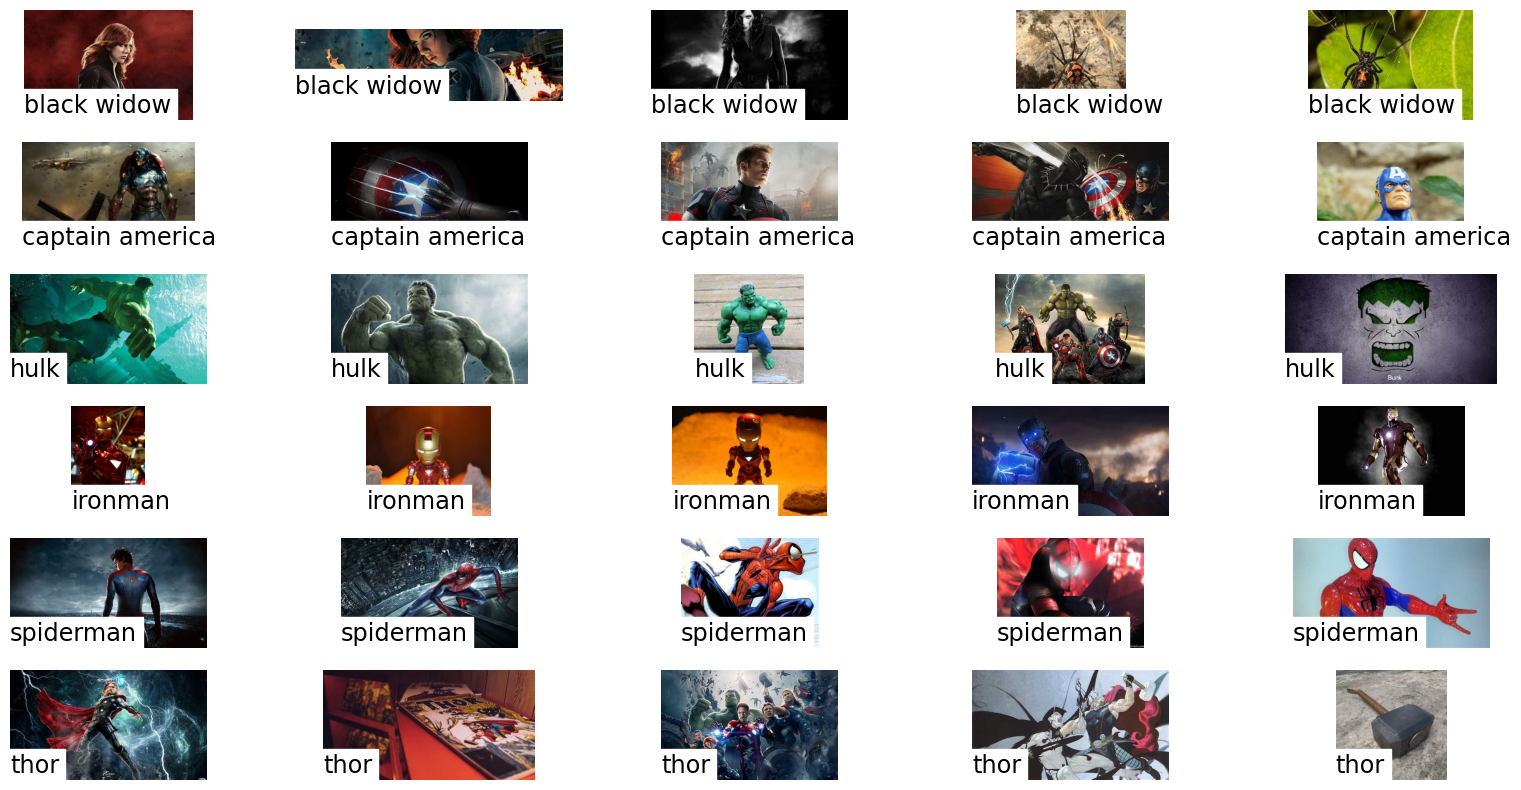

In [8]:
plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

In [9]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [10]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

In [11]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

/home/user/miniconda/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [13]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='cpu', devices=1, precision=16, max_epochs=1)
trainer.fit(classifier, train_loader, val_loader)

Seed set to 42
/home/user/miniconda/lib/python3.9/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
/home/user/miniconda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:512: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/user/miniconda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` a

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [14]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([1, 4, 2, 2, 1, 5, 2, 5])
Labels: tensor([1, 4, 0, 4, 1, 5, 0, 0])


In [15]:
notebook_login()

In [30]:
import shutil
from transformers import TrainingArguments, AutoModelForImageClassification, AutoTokenizer
from transformers.utils import logging
from datasets import load_dataset
from pathlib import Path
from sklearn.metrics import accuracy_score

import shutil
from transformers import TrainingArguments, AutoModelForImageClassification, Trainer, ViTFeatureExtractor
from transformers.utils import logging
from datasets import load_dataset
from pathlib import Path
from huggingface_hub import HfApi, HfFolder, Repository
import numpy as np
from sklearn.metrics import accuracy_score

# Configure logging
logging.set_verbosity_info()

# Define model parameters
model_id = "avengers-classifier"  # Model ID for Hugging Face Hub
description = "To classify avengers"
task_name = "Image Classification"
task_type = 'image-classification'
metric_name = 'Accuracy'
metric_type = 'accuracy'

# Load the dataset
dataset = load_dataset('imagefolder', data_dir='images')

# Split the dataset into training and evaluation sets
train_test_split = dataset['train'].train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

# Load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Preprocess the dataset
def preprocess_images(examples):
    examples['pixel_values'] = [feature_extractor(images=img, return_tensors="pt")['pixel_values'][0] for img in examples['image']]
    return examples

train_dataset = train_dataset.map(preprocess_images, batched=True)
eval_dataset = eval_dataset.map(preprocess_images, batched=True)

# Define the model
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(dataset['train'].features['label'].names),
    ignore_mismatched_sizes=True
)

# Define the compute_metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'accuracy': accuracy_score(p.label_ids, preds)}

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",          # output directory
    evaluation_strategy="epoch",     # evaluate each `epoch`
    logging_dir="./logs",            # directory for storing logs
)

# Instantiate the Trainer object
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=eval_dataset,           # evaluation dataset
    compute_metrics=compute_metrics      # define compute metrics function
)

# Evaluate the model
eval_results = trainer.evaluate()
metric_value = eval_results['eval_accuracy']

# Delete model folder if it exists
if Path('./model').exists():
    shutil.rmtree('./model')

# Get Hugging Face Hub token
token = HfFolder().get_token()
if not token:
    raise RuntimeError("You must log in to push to hub! Run notebook_login() in the cell above.")

# Get username and create repository
hf_api = HfApi()
hf_username = hf_api.whoami(token=token)['name']

# Create repository if it doesn't exist
try:
    model_url = hf_api.create_repo(repo_id=model_id, token=token, exist_ok=True)
except Exception as e:
    raise RuntimeError(f"Error creating repository: {e}")

# Clone the repository
model_repo = Repository(
    local_dir="./model", 
    clone_from=model_url,
    use_auth_token=token, 
    git_email=f"{hf_username}@users.noreply.huggingface.co", 
    git_user=hf_username
)

# Save model
model.save_pretrained(model_repo.local_dir)

# Copy over tensorboard logs from logs/ into ./model/runs/
tensorboard_logs = list(Path(training_args.logging_dir).glob('events.out*'))
if tensorboard_logs:
    model_repo_logs_path = Path(model_repo.local_dir) / 'runs'
    model_repo_logs_path.mkdir(exist_ok=True, parents=True)
    for log in tensorboard_logs:
        shutil.copy(log, model_repo_logs_path)
else:
    print("No TensorBoard logs found to copy.")

# Copy over a few example images
example_images_dir = Path(model_repo.local_dir) / 'images'
example_images_dir.mkdir(exist_ok=True, parents=True)
image_markdown_template = '''
#### {class_name}

![{class_name}](images/{example_image_path})
'''
example_images_markdown = ""
unique_labels = set(train_dataset['label'])  # Get unique labels

for class_name in unique_labels:  # Adjust to your dataset
    folder = Path(f'images/{class_name}')  # Adjust this line to point to your image folders
    image_paths = sorted(folder.glob('*'))
    if image_paths:  # Ensure the folder is not empty
        image_path = image_paths[0]
        example_image_path = example_images_dir / f"{class_name.replace(' ', '_')}{image_path.suffix}"
        shutil.copy(image_path, example_image_path)
        example_images_markdown += image_markdown_template.format(
            class_name=class_name,
            example_image_path=example_image_path.name
        )

# Prepare README.md from information gathered above
readme_txt = f"""
---
tags:
- image-classification
- pytorch
- huggingpics
metrics:
- {metric_type}

model-index:
- name: {model_id}
  results:
  - task:
      name: {task_name}
      type: {task_type}
    metrics:
      - name: {metric_name}
        type: {metric_type}
        value: {metric_value}
---

# {model_id}

{description}

## Example Images

{example_images_markdown}

""".strip()

(Path(model_repo.local_dir) / 'README.md').write_text(readme_txt)

# Push to Hugging Face Hub
commit_url = model_repo.push_to_hub()

print("Check out your model at:")
print(f"https://huggingface.co/{hf_username}/{model_id}")


Resolving data files:   0%|          | 0/300 [00:00<?, ?it/s]

loading configuration file preprocessor_config.json from cache at /home/user/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/3f49326eb077187dfe1c2a2bb15fbd74e6ab91e3/preprocessor_config.json
/home/user/miniconda/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}, {'longest_edge'}, {'max_width', 'max_height'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_fac

/home/user/miniconda/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/charliednwm/avengers-classifier into local empty directory.
Configuration saved in /data/./model/config.json
Model weights saved in /data/./model/model.safetensors


No TensorBoard logs found to copy.


Upload file model.safetensors:   0%|          | 1.00/327M [00:00<?, ?B/s]

To https://huggingface.co/charliednwm/avengers-classifier
   1d7ffee..afed219  main -> main



Check out your model at:
https://huggingface.co/charliednwm/avengers-classifier
